In [118]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import pickle
import pyccl as ccl

from torch.distributions import Uniform

import corner

# Generating cluster samples

- Start with a cluster likelihood to produce a sample of clusters with mass and redshift.
- Generate observables: $\lambda$, $M_{\rm{WL}}$, $z_{\rm{obs}}$, ...
- Apply selection function, in terms of $\lambda$ and $z_{\rm{obs}}$
- The result is our observed cluster sample

In [119]:
class Universe_simulation:
    
    def __init__( self, summary_statistic , for_simulate_for_sbi = False ):
        """
        Initialize the Simulation class.
        """
        if summary_statistic == 'stacked_counts':
            self.summary_statistic = self.stacked_counts
        elif summary_statistic == 'unbinned_counts':
            self.summary_statistic = self.unbinned_counts
        else:
            print('Your chosen summary statistic is unknown:' , summary_statistic )
        self.selection_richness = 20
        self.for_simulate_for_sbi = for_simulate_for_sbi
        # hmf properties
        self.dlog10m = 0.01
        self.log10ms = np.arange( 13.5 , 15.5 , self.dlog10m )
        self.Ms = 10**self.log10ms
        self.hmf = ccl.halos.MassFuncTinker10( mass_def='200m' )
        # Create a grid of mass and redshift values
        self.z_bins = np.arange( 0 , 1.2 , 0.05 )
        self.zs = ( self.z_bins[1:] + self.z_bins[:-1] )/2.
        mass_grid, redshift_grid = np.meshgrid( self.log10ms , self.zs )
        self.mass_grid = mass_grid
        self.redshift_grid = redshift_grid
        # Flatten the mass and redshift grids
        self.mass_values = self.mass_grid.flatten()
        self.redshift_values = self.redshift_grid.flatten()
        # for the stacked counts
        self.richness_bins = np.logspace( np.log10( 20 ), np.log10( 300 ), 15 )
        self.redshift_bins = np.linspace( 0.025 , 1.125 , 6 ) 
        # for the "unbinned" counts
        self.small_log10Mwl_bins = np.arange( 12.5 , 15.5 , 0.1 )
        self.small_richness_bins = np.logspace( np.log10( 20 ), np.log10( 300 ), 15 )
        self.small_redshift_bins = np.linspace( 0.025 , 1.125 , 6 ) 
        # survey size
        self.dOmega = 0.5 * 4*np.pi
        # fixed parameters
        self.alpha_mwl = 1
        self.sigma_mwl = 0.3 
        self.c_mwl = np.log( 1e14 )
        self.r = 0
        self.H0 = 70
        # transfer function
        #self.transfer_function = 'eisenstein_hu'
        self.transfer_function = 'boltzmann_camb'
        

    def run_simulation( self, parameter_set ):
        """
        Run the simulation with the given parameters.
        """
        richness, log10M_wl, z_clusters = self._run_simulation( parameter_set )
        
        if self.for_simulate_for_sbi:
            return torch.tensor( self.summary_statistic( richness, log10M_wl, z_clusters ) )
        else:
            return self.summary_statistic( richness, log10M_wl, z_clusters )
    

    def _run_simulation( self, parameter_set ):
        """
        Run the simulation. This contains the selection function!
        """
        
        # get the latent cluster properties, a poisson realisation
        mu_clusters, z_clusters = self.get_cluster_catalogue( parameter_set )
        
        # get the observed cluster properties
        richness, log10M_wl = self.mass_observable_relation(mu_clusters, z_clusters , parameter_set )
        
        # apply selection function
        selection = richness > self.selection_richness
        return richness[selection], log10M_wl[selection], z_clusters[selection]
        

    def get_cluster_catalogue(self, parameter_set):
        Om0, sigma8, w0 , wa, alpha_l, sigma_l, c_l = parameter_set

        # Ensure that parameters are native Python floats (not PyTorch tensors)
        Om0 = float(Om0)
        sigma8 = float(sigma8)
        w0 = float(w0)
        wa = float(wa)
        
        cosmo_params = {
                        'Omega_c': Om0 -0.05, 
                        'Omega_b': 0.05,
                        'h': self.H0 / 100,    
                        'n_s': 0.96,
                        'sigma8': sigma8,   
                        'Omega_k': 0.0 ,
                        'matter_power_spectrum' : 'linear',
                        'transfer_function': self.transfer_function,
                        'w0': w0,
                        'wa': wa,
                        'extra_parameters':{"camb": {"dark_energy_model": "ppf"}}
                    }

        # Create the CCL Cosmology object once
        cosmo = ccl.Cosmology( **cosmo_params )

        dz = 0.05
        z_bins = np.arange( 0, 1.2, dz )
        z_bin_centers = (z_bins[:-1] + z_bins[1:]) / 2.0
        scale_factor_bins = 1/( z_bins + 1 )
        scale_factors = 1 / (z_bin_centers + 1)

        # Compute comoving volumes only once
        dV = cosmo.comoving_volume_element( scale_factors ) #cosmo.comoving_volume( scale_factor_bins[1:]) - cosmo.comoving_volume( scale_factor_bins[:-1] )
        da = scale_factor_bins[:-1] - scale_factor_bins[1:]
        
        cluster_abundance = []

        for i, a in enumerate(scale_factors):
            # Calculate halo mass function for the current redshift (as scalar `a`)
            dndlog10M = self.hmf( cosmo, self.Ms, a )

            # Compute counts in each bin
            counts_per_bin = np.random.poisson( dndlog10M * dV[i] * self.dlog10m * self.dOmega * da[i] )
            cluster_abundance.append(counts_per_bin)

        cluster_abundance = np.array(cluster_abundance).flatten()

        # Use np.repeat to create the catalog based on counts in cluster_abundance
        cat_mass = np.repeat(self.mass_values, cluster_abundance)
        cat_redshift = np.repeat(self.redshift_values, cluster_abundance)
        cat_mu = np.log( 10 ** cat_mass / 1e14 )

        return cat_mu, cat_redshift

    def mass_observable_relation( self, mu , z , parameter_set ):
        
        Om0, sigma8, w0 , wa, alpha_l , sigma_l , c_l =  parameter_set
        alpha_l = alpha_l.numpy()
        sigma_l = sigma_l.numpy()
        c_l = c_l.numpy()

        mean_l = c_l + alpha_l * mu
        mean_mwl = self.c_mwl + self.alpha_mwl * mu

        cov = [ [ sigma_l**2 , self.r * self.sigma_mwl * sigma_l ] , 
                [ self.r * self.sigma_mwl * sigma_l , self.sigma_mwl**2 ] ]

        noise = np.random.multivariate_normal( [ 0 , 0 ] , cov = cov  , size = len( mu ) )

        ln_richness = mean_l + noise.T[0]
        lnM_wl = mean_mwl + noise.T[1]


        return np.exp( ln_richness  ) , np.log10( np.exp( lnM_wl ) )
    

    def unbinned_counts(self, richness, log10M_wl, z_clusters ):
        """
        Calculate the number of clusters in bins of cluster richness, redshift, and weak lensing mass.

        Parameters:
        - richness: array-like, cluster richness values
        - log10M_wl: array-like, log10 of weak lensing mass values
        - z_clusters: array-like, redshift values of the clusters
        - richness_bins: array-like, edges of the bins for richness
        - redshift_bins: array-like, edges of the bins for redshift
        - mass_bins: array-like, edges of the bins for weak lensing mass (log10)

        Returns:
        - counts: a 3D array of shape (len(richness_bins)-1, len(redshift_bins)-1, len(mass_bins)-1)
        """

        # Calculate histogram counts in 3D bins
        counts, edges = np.histogramdd(
            np.column_stack([ richness, 
                              z_clusters, 
                              log10M_wl ]),
            bins=[ self.small_richness_bins, 
                   self.small_redshift_bins, 
                   self.small_log10Mwl_bins ]
        )

        return counts.flatten()
    
    def stacked_counts( self , richness, log10M_wl, redshift ):
        """
        Calculate the number of clusters in bins of cluster richness and redshift,
        and calculate the mean cluster weak-lensing mass in these bins.

        Parameters:
        richness (array-like): Array of richness values.
        log10M_wl (array-like): Array of weak-lensing mass values (log10 scale).
        redshift (array-like): Array of redshift values.
        richness_bins (array-like): Bin edges for richness.
        redshift_bins (array-like): Bin edges for redshift.

        Returns:
        observed_cluster_abundance (2D array): Number of clusters in each bin.
        mean_log10M_wl (2D array): Mean log10 weak-lensing mass in each bin.
        """
        # Compute the 2D histogram for cluster counts
        observed_cluster_abundance, _, _ = np.histogram2d(
            richness, 
            redshift, 
            bins=[ self.richness_bins, self.redshift_bins]
        )

        # Compute the 2D histogram for the sum of log10M_wl
        sum_log10M_wl, _, _ = np.histogram2d(  richness, 
                                               redshift, 
                                               bins=[ self.richness_bins, self.redshift_bins], 
                                               weights=log10M_wl
        )

        # Calculate mean log10M_wl in each bin (avoid division by zero)
        with np.errstate(divide='ignore', invalid='ignore'):
            mean_log10M_wl = np.where( observed_cluster_abundance > 0, 
                                       sum_log10M_wl / observed_cluster_abundance, 
                                       -1 )

        return np.vstack( [ observed_cluster_abundance, mean_log10M_wl ] ).flatten()    

In [120]:
unbinned_simulator = Universe_simulation( 'unbinned_counts' )

In [121]:
stacked_simulator = Universe_simulation( 'stacked_counts' )

In [172]:
class CustomPrior(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define uniform priors for the parameters
        self.prior_uniform = utils.BoxUniform(
            low=torch.tensor([0.05, 0.5, -2, -3, 0, 0.05, 2]), 
            high=torch.tensor([1.0, 1.3, 0, 3, 2, 0.5, 5])
        )
    
    def log_prob(self, x):
        # Check the constraint w0 + wa < 0
        w0_plus_wa = x[..., 2] + x[..., 3]  # assuming w0 is at index 2 and wa at index 3
        mask = (w0_plus_wa < 0)
        return torch.where(mask, self.prior_uniform.log_prob(x), torch.tensor(-float('inf')))
    
    def sample(self, sample_shape=torch.Size()):
        if len(sample_shape) == 0:
            sample_shape = torch.Size([1])  # Default to a single sample if sample_shape is empty
            
        samples = []
        while len(samples) < sample_shape[0]:
            sample = self.prior_uniform.sample((1,))
            if (sample[..., 2] + sample[..., 3]).lt(0):  # Ensure w0 + wa < 0
                samples.append(sample)
                
        return torch.cat(samples, dim=0)

# Instantiate the custom prior
w0_plus_wa_positive_prior = CustomPrior()

In [ ]:
prior = utils.BoxUniform( low = [ 0.05 , 0.5 , -2 , -3 , 0 , 0.05 , 2 ] , 
                          high = [ 1.0 , 1.3 , 0 , 1 , 2 , 0.5 , 5 ] )

In [ ]:
obs_unbinned = unbinned_simulator.run_simulation( torch.Tensor( [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3 ] ) )

In [ ]:
obs_stack = stacked_simulator.run_simulation( torch.Tensor( [ 0.3 , 0.8 , -1. , 0 , 0.8 , 0.3 , 3 ] ) )

In [ ]:
# infer posteriors
unbinned_posterior = infer( unbinned_simulator.run_simulation , 
                            w0_plus_wa_positive_prior, 
                            method = "SNPE", 
                            num_simulations = 1000 , 
                            num_workers = 40 )

In [ ]:
# infer posteriors
stacked_posterior = infer( stacked_simulator.run_simulation , 
                           w0_plus_wa_positive_prior, 
                           method = "SNPE", 
                           num_simulations = 1000 , 
                           num_workers = 40 )

In [ ]:
nsamples = 1000000
samples_unbinned_posterior = unbinned_posterior.sample( (nsamples,), x = obs_unbinned )

In [ ]:
nsamples = 1000000
samples_unbinned_posterior = unbinned_posterior.sample( (nsamples,), x = obs_unbinned )

# Nice HMF plots, for different cosmologies.

In [7]:
mu_cat , z_cat = unbinned_simulator.get_cluster_catalogue( torch.Tensor( [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3 ] ) )
mu_cat_de , z_cat_de = unbinned_simulator.get_cluster_catalogue( torch.Tensor( [ 0.5 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3 ] ) )

In [57]:
masses = np.exp( mu_cat ) * 1e14 
masses_de = np.exp( mu_cat_de ) * 1e14 

In [69]:
mass_bins = np.logspace( 13.5 , 15.5 , 20 )
mass_cents = ( mass_bins[1:] + mass_bins[:-1] )/2.

N_0, _ = np.histogram( masses[ ( z_cat > 0.1 ) & ( z_cat < 0.2 ) ] , bins = mass_bins )
N_1, _ = np.histogram( masses[ ( z_cat > 0.5 ) & ( z_cat < 0.6 ) ] , bins = mass_bins )
N_2, _ = np.histogram( masses[ ( z_cat > 1.0 ) & ( z_cat < 1.1 ) ] , bins = mass_bins )

N_0_de, _ = np.histogram( masses_de[ ( z_cat_de > 0.1 ) & ( z_cat_de < 0.2 ) ] , bins = mass_bins )
N_1_de, _ = np.histogram( masses_de[ ( z_cat_de > 0.5 ) & ( z_cat_de < 0.6 ) ] , bins = mass_bins )
N_2_de, _ = np.histogram( masses_de[ ( z_cat_de > 1.0 ) & ( z_cat_de < 1.1 ) ] , bins = mass_bins )

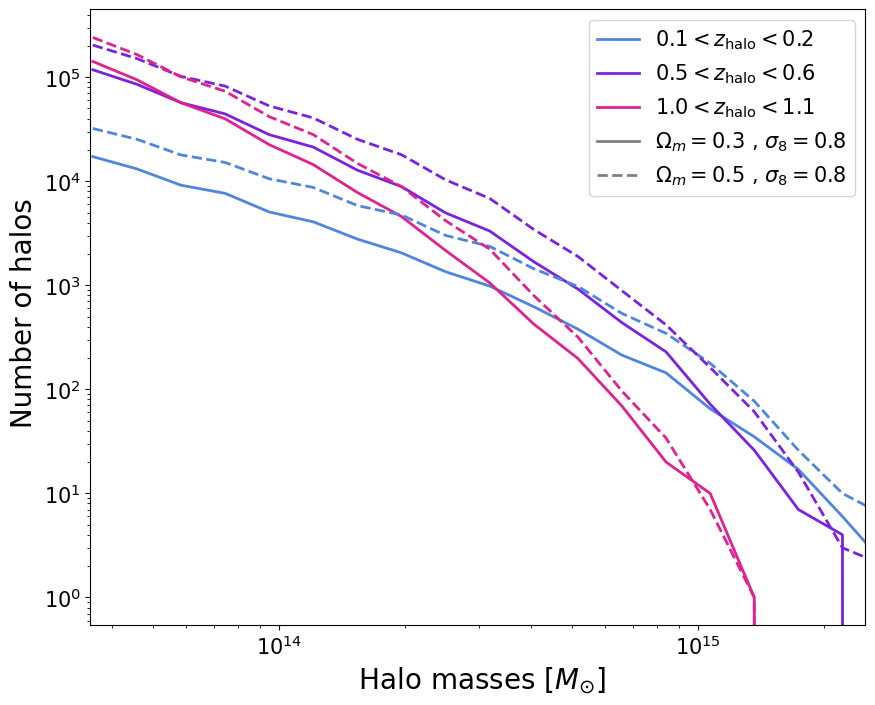

In [81]:
plt.figure( figsize = ( 10 , 8 ) )
plt.plot( mass_cents , N_0 , color = '#4e85de' , lw = 2 , label = r'$0.1 < z_{\rm{halo}} < 0.2$')
plt.plot( mass_cents , N_1 , color = '#7b22e0' , lw = 2 , label = r'$0.5 < z_{\rm{halo}} < 0.6$')
plt.plot( mass_cents , N_2 , color = '#e0228e' , lw = 2 , label = r'$1.0 < z_{\rm{halo}} < 1.1$')

plt.plot( mass_cents , N_0_de , '--' , color = '#4e85de' , lw = 2 )
plt.plot( mass_cents , N_1_de , '--' , color = '#7b22e0' , lw = 2 )
plt.plot( mass_cents , N_2_de , '--' , color = '#e0228e' , lw = 2 )
plt.xscale('log')
plt.yscale('log')

plt.xticks( fontsize = 15 )
plt.yticks( fontsize = 15 )
plt.xlabel(' Halo masses [$M_{\odot}$]' , fontsize = 20 )
plt.ylabel(' Number of halos' , fontsize = 20 )

plt.xlim( 10**13.55 , 10**15.4 )

plt.plot( [ 0 ,0 ] , [ 1e3 , 1e3 ] , 'k-' , lw = 2 ,  label = '$\Omega_m=0.3$ , $\sigma_8 = 0.8$' , alpha = 0.5 )
plt.plot( [ 0 ,0 ] , [ 1e3 , 1e3 ] , 'k--' , lw = 2 ,  label = '$\Omega_m=0.5$ , $\sigma_8 = 0.8$' , alpha = 0.5 )
plt.legend( fontsize = 15 )


In [87]:
richness, log10M_wl = unbinned_simulator.mass_observable_relation( mu_cat , z_cat , torch.Tensor( [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3 ] ) )
richness_de, log10M_wl_de = unbinned_simulator.mass_observable_relation( mu_cat_de , z_cat_de  , torch.Tensor( [ 0.5 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3 ] ) )

In [88]:
richness.min(), richness.max()

(2.058814184708846, 427.84749623626703)

In [89]:
rich_bins = np.logspace( np.log10( 10 ) , np.log10( 400 ) , 20 )
rich_cents = ( rich_bins[1:] + rich_bins[:-1] )/2.

N_0, _ = np.histogram( richness[ ( z_cat > 0.1 ) & ( z_cat < 0.2 ) ] , bins = rich_bins )
N_1, _ = np.histogram( richness[ ( z_cat > 0.5 ) & ( z_cat < 0.6 ) ] , bins = rich_bins )
N_2, _ = np.histogram( richness[ ( z_cat > 1.0 ) & ( z_cat < 1.1 ) ] , bins = rich_bins )

N_0_de, _ = np.histogram( richness_de[ ( z_cat_de > 0.1 ) & ( z_cat_de < 0.2 ) ] , bins = rich_bins )
N_1_de, _ = np.histogram( richness_de[ ( z_cat_de > 0.5 ) & ( z_cat_de < 0.6 ) ] , bins = rich_bins )
N_2_de, _ = np.histogram( richness_de[ ( z_cat_de > 1.0 ) & ( z_cat_de < 1.1 ) ] , bins = rich_bins )

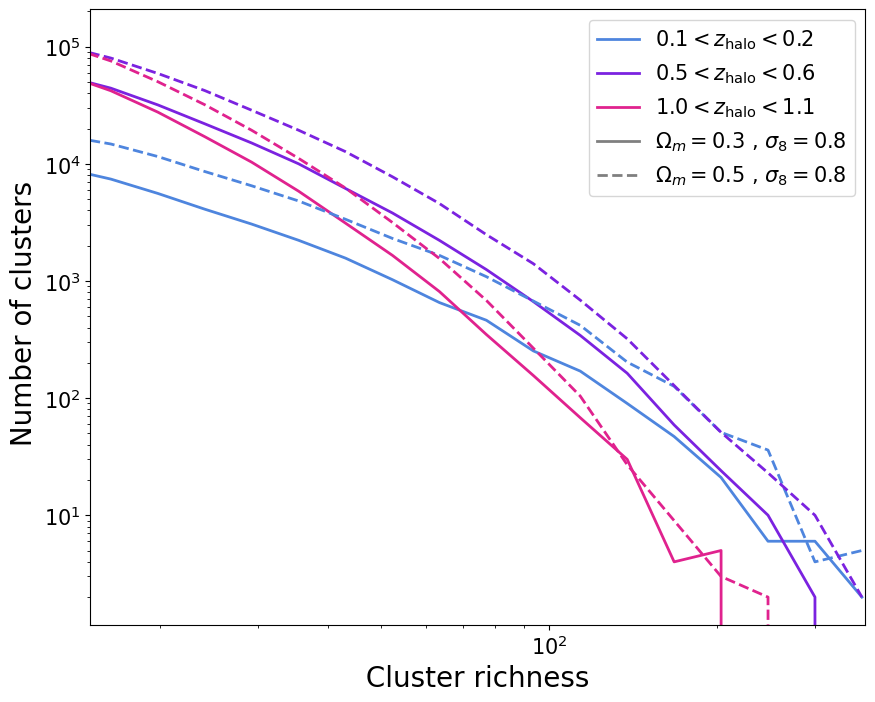

In [92]:
plt.figure( figsize = ( 10 , 8 ) )
plt.plot( rich_cents , N_0 , color = '#4e85de' , lw = 2 , label = r'$0.1 < z_{\rm{halo}} < 0.2$')
plt.plot( rich_cents , N_1 , color = '#7b22e0' , lw = 2 , label = r'$0.5 < z_{\rm{halo}} < 0.6$')
plt.plot( rich_cents , N_2 , color = '#e0228e' , lw = 2 , label = r'$1.0 < z_{\rm{halo}} < 1.1$')

plt.plot( rich_cents , N_0_de , '--' , color = '#4e85de' , lw = 2 )
plt.plot( rich_cents , N_1_de , '--' , color = '#7b22e0' , lw = 2 )
plt.plot( rich_cents , N_2_de , '--' , color = '#e0228e' , lw = 2 )
plt.xscale('log')
plt.yscale('log')

plt.xticks( fontsize = 15 )
plt.yticks( fontsize = 15 )
plt.xlabel(' Cluster richness ' , fontsize = 20 )
plt.ylabel(' Number of clusters' , fontsize = 20 )

plt.xlim( 15 , 370 )

plt.plot( [ 0 ,0 ] , [ 1e3 , 1e3 ] , 'k-' , lw = 2 ,  label = '$\Omega_m=0.3$ , $\sigma_8 = 0.8$' , alpha = 0.5 )
plt.plot( [ 0 ,0 ] , [ 1e3 , 1e3 ] , 'k--' , lw = 2 ,  label = '$\Omega_m=0.5$ , $\sigma_8 = 0.8$' , alpha = 0.5 )
plt.legend( fontsize = 15 )

In [186]:
np.min( log10M_wl )

12.899370239871619

In [141]:
mwl_bins = np.logspace( 12.9 , 15.5 , 20 )
mwl_cents = ( mwl_bins[1:] + mwl_bins[:-1] )/2.

N_0, _ = np.histogram( 10**log10M_wl[ ( z_cat > 0.1 ) & ( z_cat < 0.2 ) ] , bins = mwl_bins )
N_1, _ = np.histogram( 10**log10M_wl[ ( z_cat > 0.5 ) & ( z_cat < 0.6 ) ] , bins = mwl_bins )
N_2, _ = np.histogram( 10**log10M_wl[ ( z_cat > 1.0 ) & ( z_cat < 1.1 ) ] , bins = mwl_bins )

N_0_de, _ = np.histogram( 10**log10M_wl_de[ ( z_cat_de > 0.1 ) & ( z_cat_de < 0.2 ) ] , bins = mwl_bins )
N_1_de, _ = np.histogram( 10**log10M_wl_de[ ( z_cat_de > 0.5 ) & ( z_cat_de < 0.6 ) ] , bins = mwl_bins )
N_2_de, _ = np.histogram( 10**log10M_wl_de[ ( z_cat_de > 1.0 ) & ( z_cat_de < 1.1 ) ] , bins = mwl_bins )

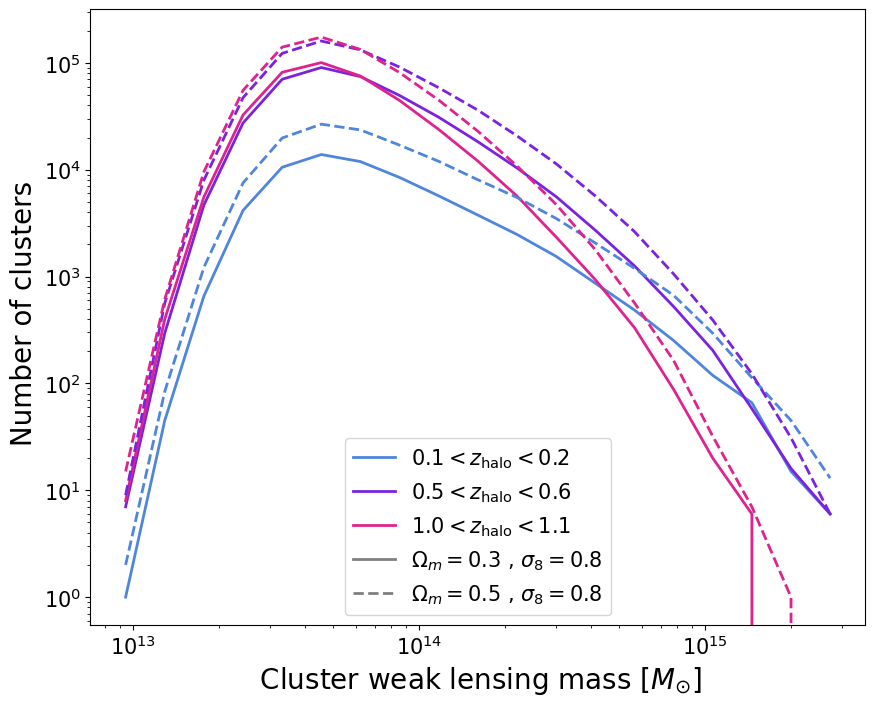

In [142]:
plt.figure( figsize = ( 10 , 8 ) )
plt.plot( mwl_cents , N_0 , color = '#4e85de' , lw = 2 , label = r'$0.1 < z_{\rm{halo}} < 0.2$')
plt.plot( mwl_cents , N_1 , color = '#7b22e0' , lw = 2 , label = r'$0.5 < z_{\rm{halo}} < 0.6$')
plt.plot( mwl_cents , N_2 , color = '#e0228e' , lw = 2 , label = r'$1.0 < z_{\rm{halo}} < 1.1$')

plt.plot( mwl_cents , N_0_de , '--' , color = '#4e85de' , lw = 2 )
plt.plot( mwl_cents , N_1_de , '--' , color = '#7b22e0' , lw = 2 )
plt.plot( mwl_cents , N_2_de , '--' , color = '#e0228e' , lw = 2 )
plt.xscale('log')
plt.yscale('log')

plt.xticks( fontsize = 15 )
plt.yticks( fontsize = 15 )
plt.xlabel(' Cluster weak lensing mass [$M_{\odot}$] ' , fontsize = 20 )
plt.ylabel(' Number of clusters' , fontsize = 20 )

#plt.xlim( 10**13.5 , 10**15.5 )

plt.plot( [ 0 ,0 ] , [ 1e3 , 1e3 ] , 'k-' , lw = 2 ,  label = '$\Omega_m=0.3$ , $\sigma_8 = 0.8$' , alpha = 0.5 )
plt.plot( [ 0 ,0 ] , [ 1e3 , 1e3 ] , 'k--' , lw = 2 ,  label = '$\Omega_m=0.5$ , $\sigma_8 = 0.8$' , alpha = 0.5 )
plt.legend( fontsize = 15 )

In [93]:
# mean mass richness relation...
from scipy.stats import binned_statistic

In [98]:
rich_bins = np.logspace( np.log10( 10 ) , np.log10( 400 ) , 20 )
rich_cents = ( rich_bins[1:] + rich_bins[:-1] )/2.

mean_Mwl_0, _ , _ = binned_statistic( richness[ ( z_cat > 0.1 ) & ( z_cat < 0.2 ) ], 
                                  log10M_wl[ ( z_cat > 0.1 ) & ( z_cat < 0.2 ) ] , 
                                  statistic ='mean' , bins = rich_bins )

mean_Mwl_1, _ , _ = binned_statistic( richness[ ( z_cat > 0.5 ) & ( z_cat < 0.6 ) ], 
                                  log10M_wl[ ( z_cat > 0.5 ) & ( z_cat < 0.6 ) ] , 
                                  statistic ='mean' , bins = rich_bins )

mean_Mwl_2, _ , _ = binned_statistic( richness[ ( z_cat > 1.0 ) & ( z_cat < 1.1 ) ], 
                                  log10M_wl[ ( z_cat > 1.0 ) & ( z_cat < 1.1 ) ] , 
                                  statistic ='mean' , bins = rich_bins )

mean_Mwl_0_de, _ , _ = binned_statistic( richness_de[ ( z_cat_de > 0.1 ) & ( z_cat_de < 0.2 ) ], 
                                     log10M_wl_de[ ( z_cat_de > 0.1 ) & ( z_cat_de < 0.2 ) ] , 
                                      statistic ='mean' , bins = rich_bins )

mean_Mwl_1_de, _ , _ = binned_statistic( richness_de[ ( z_cat_de > 0.5 ) & ( z_cat_de < 0.6 ) ], 
                                     log10M_wl_de[ ( z_cat_de > 0.5 ) & ( z_cat_de < 0.6 ) ] , 
                                      statistic ='mean' , bins = rich_bins )

mean_Mwl_2_de, _ , _ = binned_statistic( richness_de[ ( z_cat_de > 1.0 ) & ( z_cat_de < 1.1 ) ] ,
                                     log10M_wl_de[ ( z_cat_de > 1.0 ) & ( z_cat_de < 1.1 ) ] , 
                                      statistic ='mean' , bins = rich_bins )

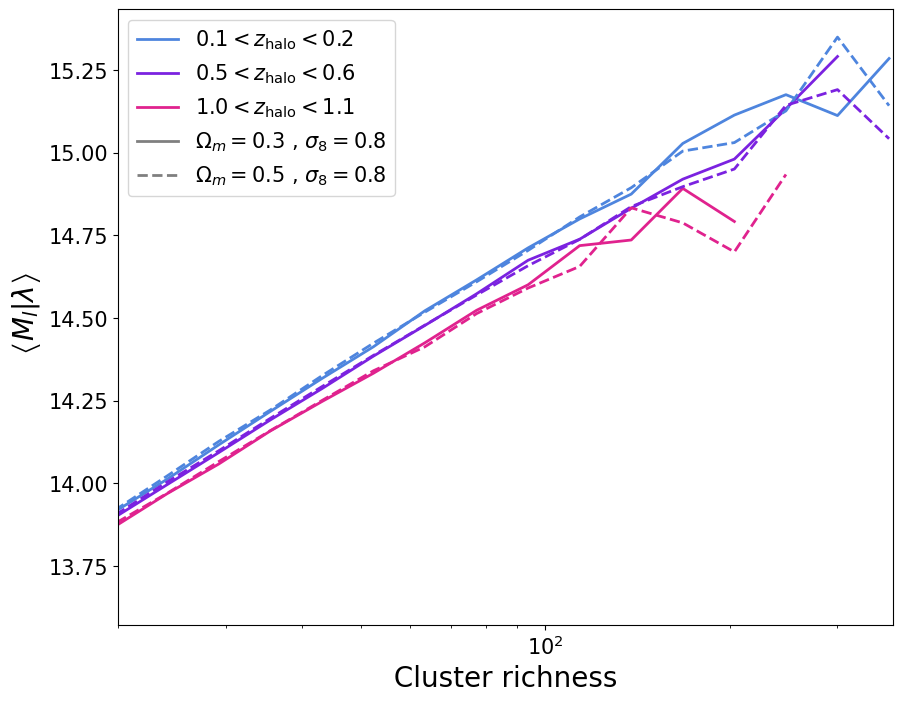

In [107]:
plt.figure( figsize = ( 10 , 8 ) )
plt.plot( rich_cents , mean_Mwl_0 , color = '#4e85de' , lw = 2 , label = r'$0.1 < z_{\rm{halo}} < 0.2$')
plt.plot( rich_cents , mean_Mwl_1 , color = '#7b22e0' , lw = 2 , label = r'$0.5 < z_{\rm{halo}} < 0.6$')
plt.plot( rich_cents , mean_Mwl_2 , color = '#e0228e' , lw = 2 , label = r'$1.0 < z_{\rm{halo}} < 1.1$')

plt.plot( rich_cents , mean_Mwl_0_de , '--' , color = '#4e85de' , lw = 2 )
plt.plot( rich_cents , mean_Mwl_1_de , '--' , color = '#7b22e0' , lw = 2 )
plt.plot( rich_cents , mean_Mwl_2_de , '--' , color = '#e0228e' , lw = 2 )
plt.xscale('log')
#plt.yscale('log')

# plt.plot( rich_cents , np.log10( 1e14 * np.exp( ( np.log( rich_cents ) - 3 ) / 0.8 ) ) , 'k-', lw = 2 ,  label ='Input relation' )

plt.xticks( fontsize = 15 )
plt.yticks( fontsize = 15 )
plt.xlabel(' Cluster richness ' , fontsize = 20 )
plt.ylabel(r' $\left< M_{l} | \lambda \right>$' , fontsize = 20 )

plt.xlim( 20 , 370 )

plt.plot( [ 0 ,0 ] , [ 14 , 14 ] , 'k-' , lw = 2 ,  label = '$\Omega_m=0.3$ , $\sigma_8 = 0.8$' , alpha = 0.5 )
plt.plot( [ 0 ,0 ] , [ 14 , 14 ] , 'k--' , lw = 2 ,  label = '$\Omega_m=0.5$ , $\sigma_8 = 0.8$' , alpha = 0.5 )
plt.legend( fontsize = 15 )

In [8]:
mu_cat.shape

(3471662,)

In [9]:
z_cat.shape

(3471662,)

In [6]:
# alpha_l , sigma_l , c_l

In [7]:
unbinned_simulator.dOmega

6.283185307179586

In [113]:
obs_unbinned = unbinned_simulator.run_simulation( torch.Tensor( [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3 ] ) )

In [114]:
obs_unbinned

array([0., 0., 1., ..., 0., 0., 0.])

In [9]:
# %timeit unbinned_simulator.get_cluster_catalogue( torch.Tensor( [ 0.3 , 0.8 , 0.8 , 0.3 , 3 ] ) )

In [10]:
# %timeit obs_unbinned = unbinned_simulator.run_simulation( torch.Tensor( [ 0.3 , 0.8 , 0.8 , 0.3 , 3 ] ) )

In [11]:
np.sum( obs_unbinned )

591977.0

In [115]:
obs_stack = stacked_simulator.run_simulation( torch.Tensor( [ 0.3 , 0.8 , -1. , 0 , 0.8 , 0.3 , 3 ] ) )

In [116]:
obs_stack.shape

(140,)

In [117]:
obs_stack

array([1.00940000e+04, 3.38670000e+04, 6.55580000e+04, 5.43950000e+04,
       5.52620000e+04, 7.27100000e+03, 2.36570000e+04, 4.44870000e+04,
       3.51850000e+04, 3.35260000e+04, 5.40200000e+03, 1.66320000e+04,
       2.93560000e+04, 2.16580000e+04, 2.00280000e+04, 3.69100000e+03,
       1.11010000e+04, 1.89100000e+04, 1.33510000e+04, 1.11230000e+04,
       2.48500000e+03, 7.32900000e+03, 1.16080000e+04, 7.57700000e+03,
       6.11300000e+03, 1.61000000e+03, 4.65600000e+03, 6.96600000e+03,
       4.21400000e+03, 3.07500000e+03, 1.08600000e+03, 2.72200000e+03,
       4.02200000e+03, 2.22000000e+03, 1.42100000e+03, 6.95000000e+02,
       1.60400000e+03, 2.07500000e+03, 1.08100000e+03, 6.78000000e+02,
       3.76000000e+02, 9.29000000e+02, 1.08300000e+03, 4.35000000e+02,
       2.40000000e+02, 2.28000000e+02, 4.68000000e+02, 5.27000000e+02,
       2.31000000e+02, 1.05000000e+02, 1.36000000e+02, 2.27000000e+02,
       2.28000000e+02, 1.04000000e+02, 4.90000000e+01, 5.90000000e+01,
      

Run SBI

In [15]:
class CustomPrior(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define uniform priors for the parameters
        self.prior_uniform = utils.BoxUniform(
            low=torch.tensor([0.05, 0.5, -2, -3, 0, 0.05, 2]), 
            high=torch.tensor([1.0, 1.3, 0, 3, 2, 0.5, 5])
        )
    
    def log_prob(self, x):
        # Check the constraint w0 + wa < 0
        w0_plus_wa = x[..., 2] + x[..., 3]  # assuming w0 is at index 2 and wa at index 3
        mask = (w0_plus_wa < 0)
        return torch.where(mask, self.prior_uniform.log_prob(x), torch.tensor(-float('inf')))
    
    def sample(self, sample_shape=torch.Size()):
        if len(sample_shape) == 0:
            sample_shape = torch.Size([1])  # Default to a single sample if sample_shape is empty
            
        samples = []
        while len(samples) < sample_shape[0]:
            sample = self.prior_uniform.sample((1,))
            if (sample[..., 2] + sample[..., 3]).lt(0):  # Ensure w0 + wa < 0
                samples.append(sample)
                
        return torch.cat(samples, dim=0)

# Instantiate the custom prior
w0_plus_wa_positive_prior = CustomPrior()

In [21]:
prior = utils.BoxUniform( low = [ 0.05 , 0.5 , -2 , -3 , 0 , 0.05 , 2 ] , 
                          high = [ 1.0 , 1.3 , 0 , 1 , 2 , 0.5 , 5 ] )

In [22]:
# infer posteriors
unbinned_posterior = infer( unbinned_simulator.run_simulation , 
                            w0_plus_wa_positive_prior, 
                            method = "SNPE", 
                            num_simulations = 1000 , 
                            num_workers = 40 )

Running 1000 simulations in 1000 batches.: 100%|██████████| 1000/1000 [09:54<00:00,  1.68it/s]


 Neural network successfully converged after 46 epochs.

In [ ]:
# unbinned_likelihood = infer( unbinned_simulator.run_simulation , 
#                             prior, 
#                             method = "SNLE", 
#                             num_simulations = 1000 , 
#                             num_workers = 40 )

In [ ]:
# unbinned_likelihood.sample( (nsamples,), x = obs_unbinned )

In [ ]:
# with open('small_unbinned_posterior.pkl', "wb") as handle:
#     pickle.dump( unbinned_posterior, handle)

In [ ]:
# with open('small_unbinned_posterior.pkl', 'rb') as file:
#     unbinned_posterior = pickle.load(file)

In [ ]:
# with open('unbinned_posterior.pkl', 'rb') as file:
#     unbinned_posterior = pickle.load(file)

In [124]:
with open('unbinned_posterior_long.pkl', 'rb') as file:
    unbinned_posterior = pickle.load(file)

In [125]:
nsamples = 1000000
samples_unbinned_posterior = unbinned_posterior.sample( (nsamples,), x = obs_unbinned )

Drawing 1000000 posterior samples: 100%|██████████| 1000000/1000000 [00:24<00:00, 40117.16it/s]


In [ ]:
# labels = ['$\Omega_m$' , '$\sigma_8$' , '$w_0$', '$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]

labels = ['$\Omega_m$' , '$\sigma_8$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3  ]
#truths = [ 264 , 48 , 369 , np.nan]
figure = corner.corner( samples_unbinned_posterior.numpy() , 
                       levels = [ 0.393, 0.865 ] ,  
                       bins = 40 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})
plt.savefig('3d_bins.pdf')
print()

In [26]:
print('hi')

hi


In [30]:
# infer posteriors
stacked_posterior = infer( stacked_simulator.run_simulation , 
                           w0_plus_wa_positive_prior, 
                           method = "SNPE", 
                           num_simulations = 1000 , 
                           num_workers = 40 )

Running 1000 simulations in 1000 batches.: 100%|██████████| 1000/1000 [09:56<00:00,  1.68it/s]


 Neural network successfully converged after 58 epochs.

In [31]:
# with open('small_stacked_posterior.pkl', "wb") as handle:
#     pickle.dump( stacked_posterior, handle)

In [32]:
# with open('small_stacked_posterior.pkl', 'rb') as file:
#     stacked_posterior = pickle.load(file)

In [33]:
# with open('stacked_posterior.pkl', 'rb') as file:
#     stacked_posterior = pickle.load(file)

In [122]:
with open('stacked_posterior_long.pkl', 'rb') as file:
    stacked_posterior = pickle.load(file)

Look at the posteriors

In [123]:
nsamples = 1000000
samples_stacked_posterior = stacked_posterior.sample( (nsamples,), x = obs_stack )

Drawing 1000000 posterior samples: 100%|██████████| 1000000/1000000 [00:10<00:00, 99664.72it/s]


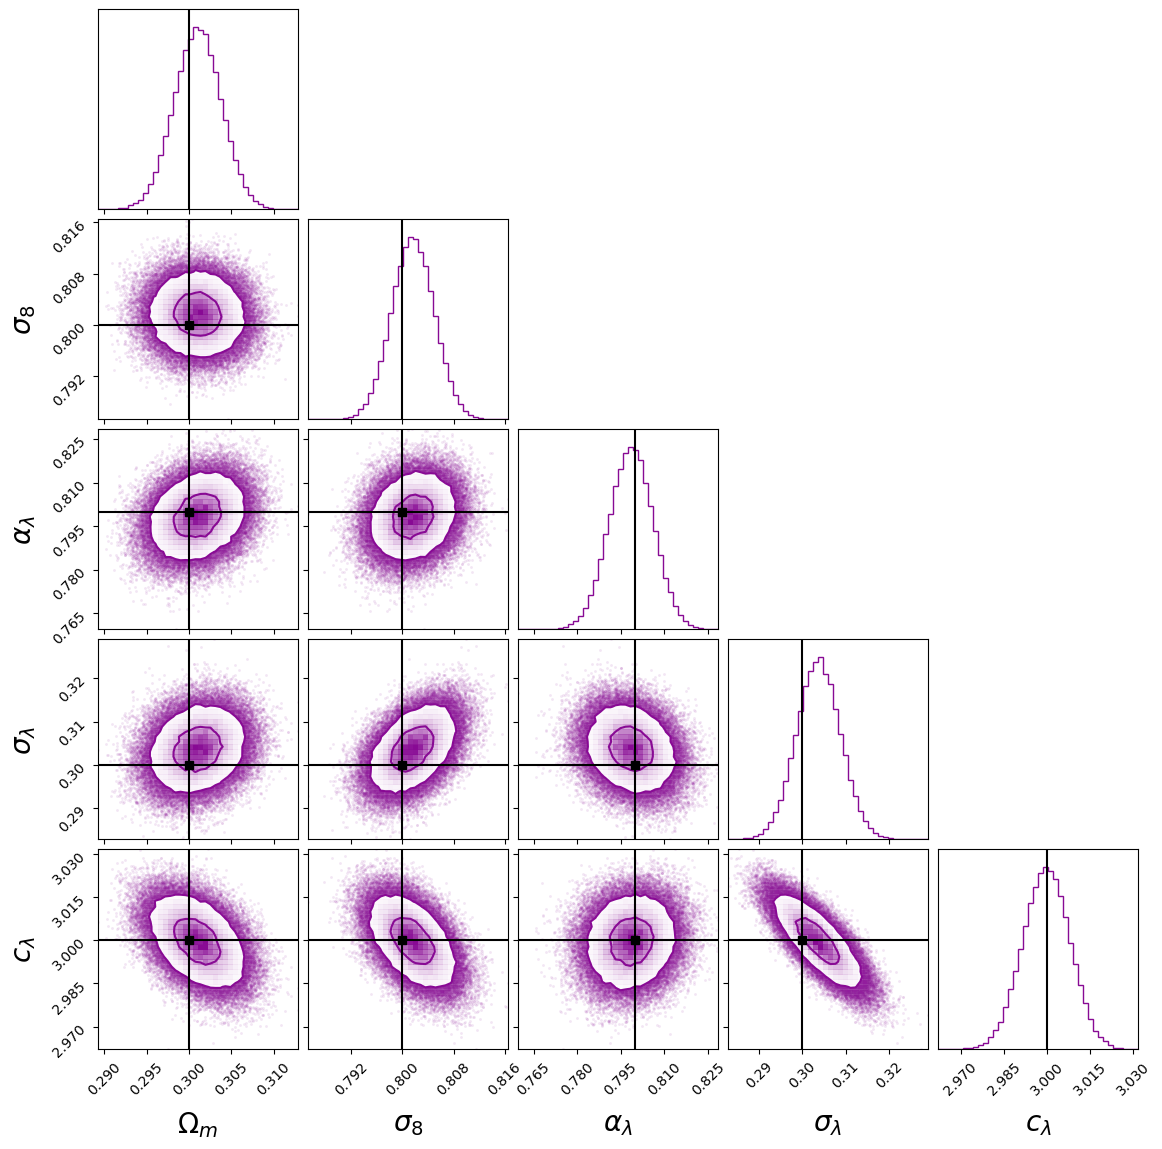

In [46]:
#labels = ['$\Omega_m$' , '$\sigma_8$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
#truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3  ]
# labels = ['$\Omega_m$' , '$\sigma_8$' , '$w_0$', '$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]


labels = ['$\Omega_m$' , '$\sigma_8$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3  ]

#truths = [ 264 , 48 , 369 , np.nan]
figure = corner.corner( samples_stacked_posterior.numpy() , 
                       levels = [ 0.393, 0.865 ] ,  
                       bins = 40 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})
plt.savefig('2d_bins.pdf')
print()

In [47]:
samples_unbinned_posterior.numpy().shape

(100000, 5)

In [156]:
np.mean( samples_unbinned_posterior.numpy() , axis = 0 )

array([0.30079478, 0.8097092 , 0.79443914, 0.29641747, 3.0005493 ],
      dtype=float32)

In [133]:
truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3  ]

In [134]:
up_centred = samples_unbinned_posterior.numpy() - np.median( samples_unbinned_posterior.numpy() , axis = 0 ) + truths 
sp_centred = samples_stacked_posterior.numpy() - np.median( samples_stacked_posterior.numpy() , axis = 0 ) + truths 

In [135]:
np.mean( up_centred , axis = 0)

array([0.3000055 , 0.80000184, 0.79997637, 0.2999927 , 3.00003336])

In [136]:
np.mean( up_centred , axis = 0)

array([0.3000055 , 0.80000184, 0.79997637, 0.2999927 , 3.00003336])

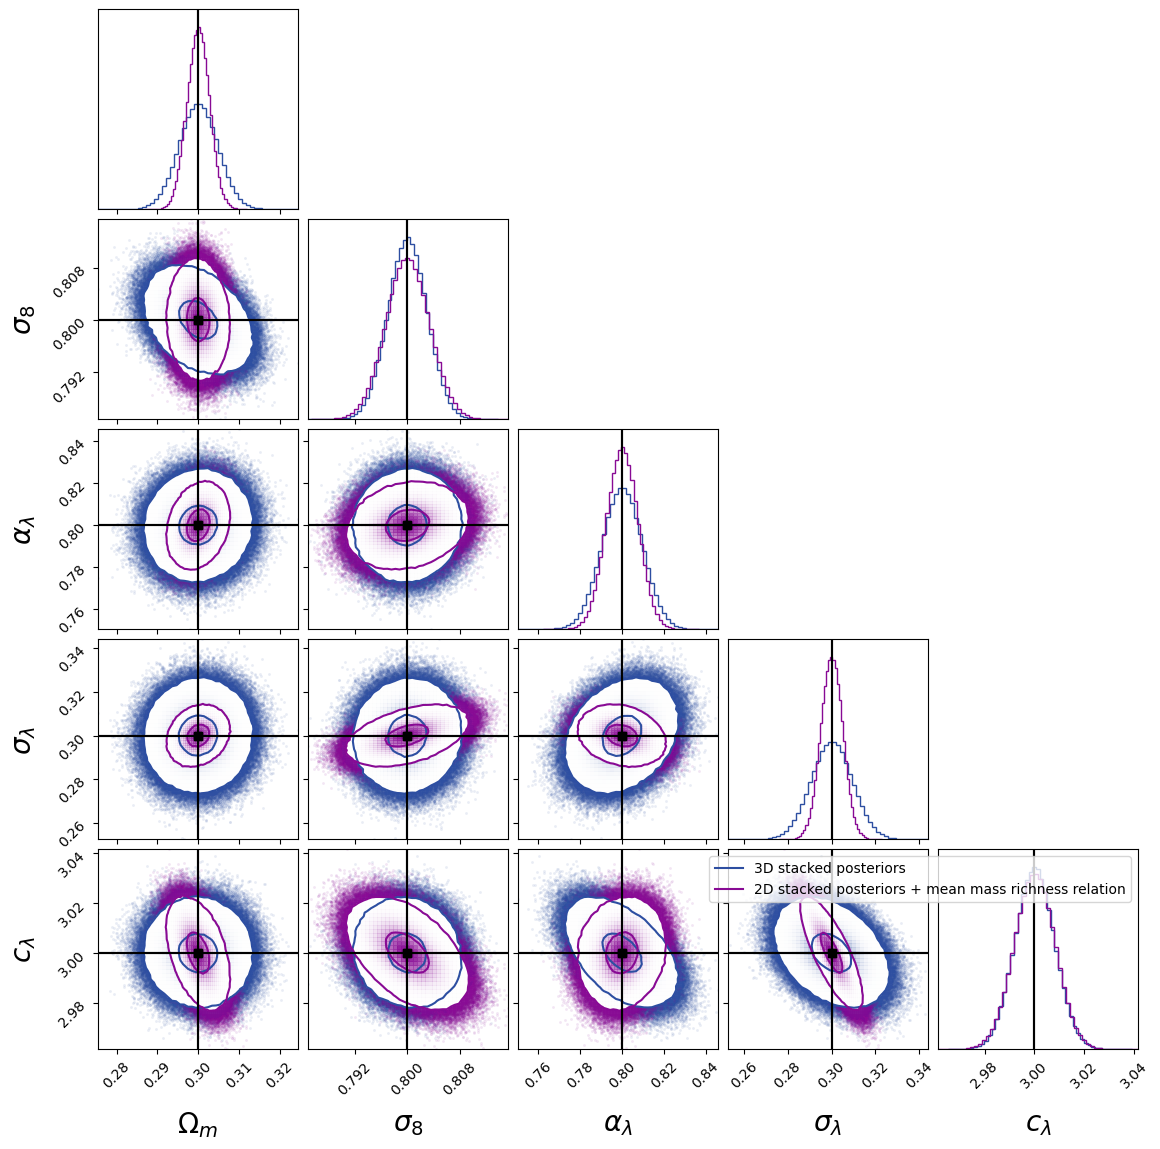

In [137]:
limits = [ ( 180 , 360 ), ( -20 , 60 ) , ( 0 , 200  ) ,( -0.01 , -0.002 )]
labels = ['$\Omega_m$' , '$\sigma_8$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']


# labels = ['$\Omega_m$' , '$\sigma_8$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3  ]


figure = corner.corner( up_centred, 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#2d4ea1',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25} )

corner.corner( sp_centred , fig = figure , 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25}  )

plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = '3D stacked posteriors')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = '2D stacked posteriors + mean mass richness relation')
plt.legend( loc="upper right" )
# plt.savefig('both_bins.pdf')


print()

In [128]:
from IPython.display import display, Math

In [159]:
samples = [samples_unbinned_posterior.numpy(), samples_stacked_posterior.numpy()]

sample_labels = ["3D (Unbinned): ", "2D (Stacked): "]
parameters = [r'$\Omega_m$', r'$\sigma_8$', r'$\alpha_{\lambda}$', r'$\sigma_{\lambda}$', r'$c_{\lambda}$']

j = 0
all_vals = []
error_ratios = []

print("Posterior Parameter Values and Errors:\n")

for sample in samples:

    output_line = sample_labels[j]
    vals = []

    for i in range(len(sample[0])):

        # Compute the 16th, 50th, and 84th percentiles
        mcmc = np.percentile(sample[:, i], [16, 50, 84])
        q = np.diff(mcmc)  # q[0] = lower error, q[1] = upper error
        
        # Format the output string for each parameter
        txt = r"${0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(mcmc[1], q[1], q[0])
        vals.append(f' & {txt}')
        
        # Append to the output line for visual output
        output_line += txt + "  |   "

    all_vals.append(''.join(vals))
    
    # Display each approach's results with the sample label
    display(Math(output_line))
    j += 1

# Now compute the ratio between the 1-sigma errors of each approach
print("\nRatio between the 1-sigma errors of each approach (Unbinned / Stacked):\n")

for i in range(len(samples[0][0])):  # Loop through parameters

    # Get the uncertainties for both approaches (q = [lower error, upper error])
    q_unbinned = np.diff(np.percentile(samples[0][:, i], [16, 50, 84]))
    q_stacked = np.diff(np.percentile(samples[1][:, i], [16, 50, 84]))

    # Compute the ratio of the errors (average the lower and upper uncertainties)
    ratio = (q_unbinned[0] + q_unbinned[1]) / (q_stacked[0] + q_stacked[1])
    error_ratios.append(ratio)

    # Format the output string using LaTeX, keeping everything on one line
    ratio_output = r"{0}: \frac{{\sigma_{{3D}}}}{{\sigma_{{2D}}}} = {1:.3f}".format(parameters[i], ratio)
    
    # Display each ratio with the parameter label
    display(Math(ratio_output))





Posterior Parameter Values and Errors:



<IPython.core.display.Math object>

<IPython.core.display.Math object>


Ratio between the 1-sigma errors of each approach (Unbinned / Stacked):



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [165]:
# Now compute the ratio between the 1-sigma errors of each approach
print("\nRatio between the 1-sigma errors of each approach (Unbinned / Stacked):\n")

samples = [samples_unbinned_posterior.numpy(), samples_stacked_posterior.numpy()]

sample_labels = ["3D (Unbinned): ", "2D (Stacked): "]
parameters = [r'$\Omega_m$', r'$\sigma_8$', r'$\alpha_{\lambda}$', r'$\sigma_{\lambda}$', r'$c_{\lambda}$']

for i in range(len(samples[0][0])):  # Loop through parameters

    # Get the uncertainties for both approaches (q = [lower error, upper error])
    q_unbinned = np.diff(np.percentile(samples[0][:, i], [16, 50, 84]))
    q_stacked = np.diff(np.percentile(samples[1][:, i], [16, 50, 84]))

    # Compute the ratio of the errors (average the lower and upper uncertainties)
    ratio = (q_unbinned[0] + q_unbinned[1]) / (q_stacked[0] + q_stacked[1])
    error_ratios.append(ratio)

    # Format the output string using LaTeX, keeping everything on one line
    ratio_output = r"{0} : {1:.3f}   ".format(parameters[i], ratio)
    
    # Display each ratio with the parameter label
    display(Math(ratio_output))


Ratio between the 1-sigma errors of each approach (Unbinned / Stacked):



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [144]:
with open('unbinned_posterior_r.pkl', 'rb') as file:
    unbinned_posterior_r = pickle.load(file)

In [145]:
with open('stacked_posterior_r.pkl', 'rb') as file:
    stacked_posterior_r = pickle.load(file)

In [146]:
nsamples = 1000000
samples_stacked_posterior_r = stacked_posterior_r.sample( (nsamples,), x = obs_stack )

Drawing 1000000 posterior samples: 1003168it [00:10, 97678.81it/s]                             


In [147]:
nsamples = 1000000
samples_unbinned_posterior_r = unbinned_posterior_r.sample( (nsamples,), x = obs_unbinned )

Drawing 1000000 posterior samples: 1002219it [01:05, 15234.01it/s]                            


In [ ]:
labels = ['$\Omega_m$' , '$\sigma_8$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$' , '$r$']
truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3 , 0 ]


# labels = ['$\Omega_m$' , '$\sigma_8$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3  ]


figure = corner.corner( samples_unbinned_posterior_r.numpy(), 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#2d4ea1',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25} )

corner.corner( samples_stacked_posterior_r.numpy() , fig = figure , 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25}  )

plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = '3D stacked posteriors')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = '2D stacked posteriors + mean mass richness relation')
plt.legend( loc="upper right" )
plt.savefig('both_bins.pdf')


print()

In [104]:
up_centred = samples_unbinned_posterior_r.numpy() - np.median( samples_unbinned_posterior_r.numpy() , axis = 0 ) + truths 
sp_centred = samples_stacked_posterior_r.numpy() - np.median( samples_stacked_posterior_r.numpy() , axis = 0 ) + truths 

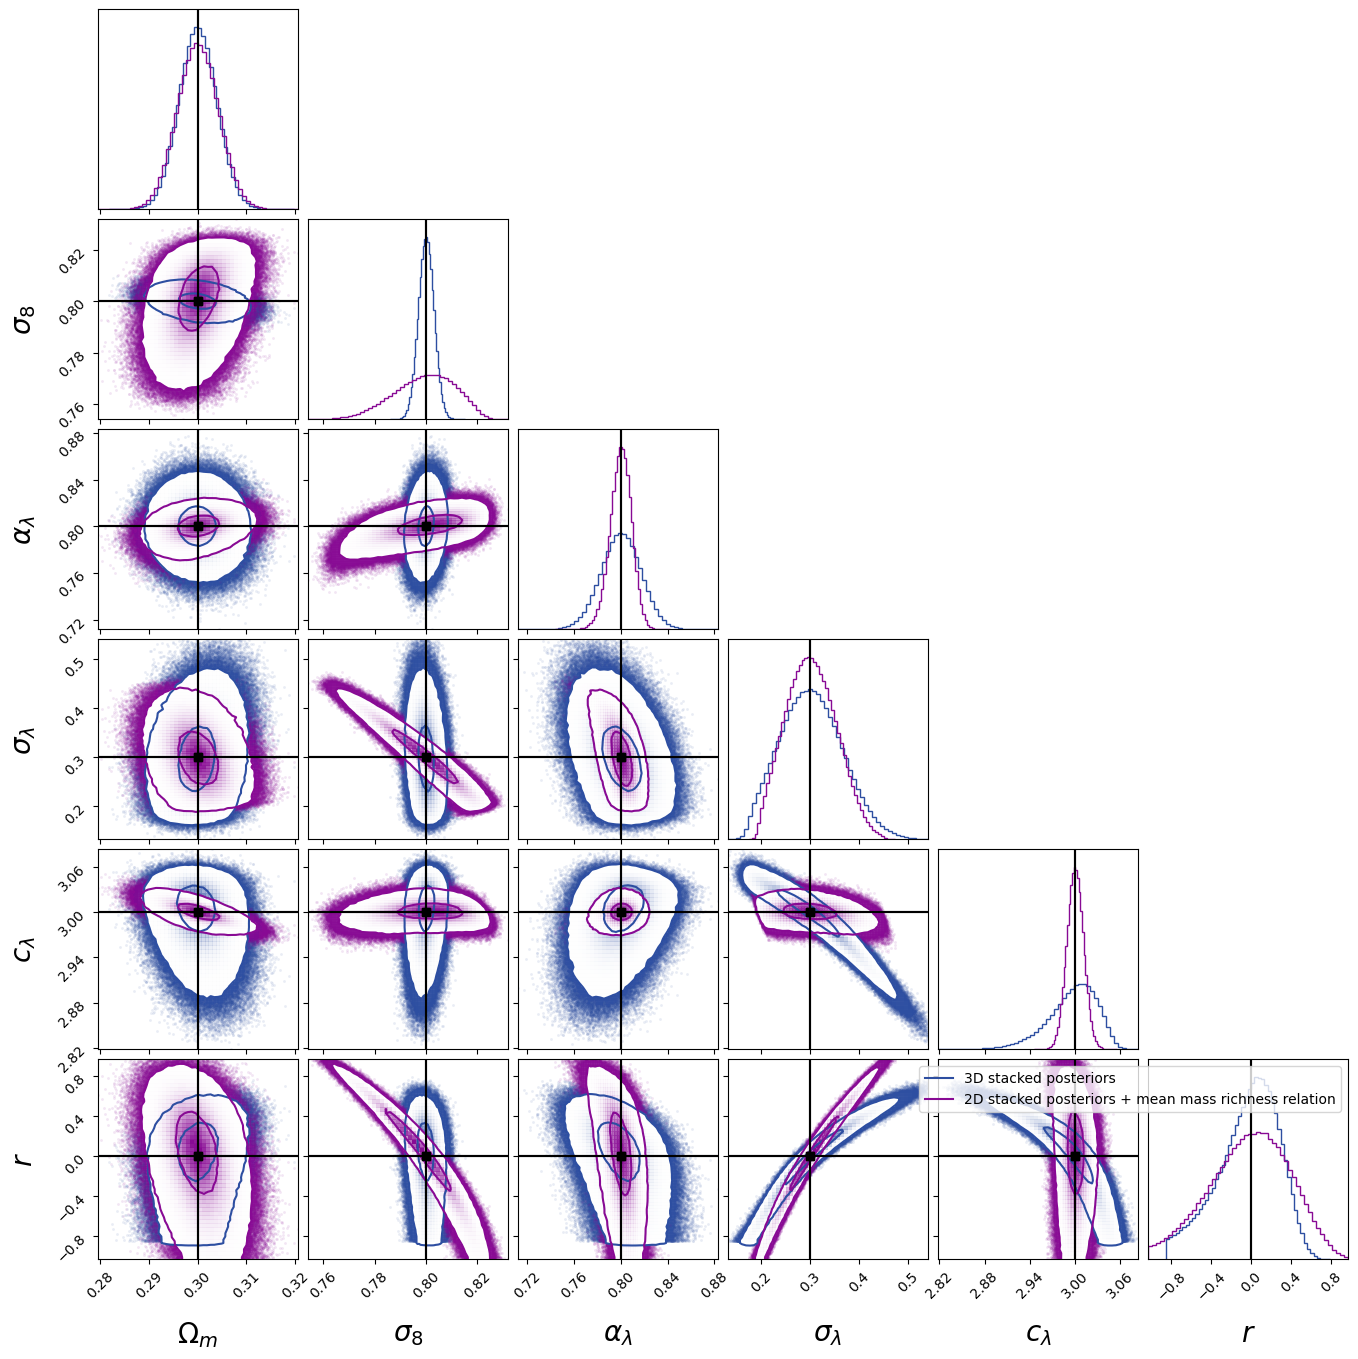

In [111]:
labels = ['$\Omega_m$' , '$\sigma_8$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$' , '$r$']
truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3 , 0 ]

figure = corner.corner( up_centred, 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#2d4ea1',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25} )

corner.corner( sp_centred , fig = figure , 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25}  )

plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = '3D stacked posteriors')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = '2D stacked posteriors + mean mass richness relation')
plt.legend( loc="upper right" )
plt.savefig('both_bins_r.pdf')


print()

In [103]:
samples = [ samples_unbinned_posterior_r.numpy(), samples_stacked_posterior_r.numpy()  ]

sample_labels = [ "3D:     ", "2D:     "  ]

j = 0
all_vals = []

print(r'      $\Omega_m$ $\sigma_8$     $\alpha_l$   $\sigma_{\lambda}$    $c_{\lambda}$    r')

for sample in samples:

    output_line = sample_labels[j]
    
    vals = []

    for i in range( len( sample[0])):

        mcmc = np.percentile(sample[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "{0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}".format(mcmc[1], q[0], q[1], labels[j][i])
        
        vals.append( ' & $' + str( np.round(mcmc[1],3) ) +  '^{'  + str( np.round( q[0] , 3 ) ) +  '}_{' +  str( np.round( q[1] , 3 ) )  +'}$ '  )

        # Append to the output_line
        output_line += txt + "|   "
        
    all_vals.append( ''.join(vals) )

    # Print the entire line
    display(Math(output_line))
    j += 1

      $\Omega_m$ $\sigma_8$     $\alpha_l$   $\sigma_{\lambda}$    $c_{\lambda}$    r


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [169]:
# Now compute the ratio between the 1-sigma errors of each approach
print("\nRatio between the 1-sigma errors of each approach (Unbinned / Stacked):\n")

samples = [samples_unbinned_posterior_r.numpy(), samples_stacked_posterior_r.numpy()]

sample_labels = ["3D (Unbinned): ", "2D (Stacked): "]
parameters = ['$\Omega_m$' , '$\sigma_8$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$' , '$r$']

for i in range(len(samples[0][0])):  # Loop through parameters

    # Get the uncertainties for both approaches (q = [lower error, upper error])
    q_unbinned = np.diff(np.percentile(samples[0][:, i], [16, 50, 84]))
    q_stacked = np.diff(np.percentile(samples[1][:, i], [16, 50, 84]))

    # Compute the ratio of the errors (average the lower and upper uncertainties)
    ratio = (q_unbinned[0] + q_unbinned[1]) / (q_stacked[0] + q_stacked[1])
    error_ratios.append(ratio)

    # Format the output string using LaTeX, keeping everything on one line
    ratio_output = r"{0} : {1:.3f}           ".format(parameters[i], ratio)
    
    # Display each ratio with the parameter label
    display(Math(ratio_output))


Ratio between the 1-sigma errors of each approach (Unbinned / Stacked):



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [173]:
with open('unbinned_posterior_w0wa.pkl', 'rb') as file:
    unbinned_posterior_w0wa = pickle.load(file)

In [174]:
with open('stacked_posterior_w0wa.pkl', 'rb') as file:
    stacked_posterior_w0wa = pickle.load(file)

In [175]:
nsamples = 1000000
samples_unbinned_posterior_w0wa = unbinned_posterior_w0wa.sample( (nsamples,), x = obs_unbinned )

Drawing 1000000 posterior samples: 100%|██████████| 1000000/1000000 [00:31<00:00, 31384.14it/s]


In [182]:
nsamples = 1000000
samples_stacked_posterior_w0wa = stacked_posterior_w0wa.sample( (nsamples,), x = obs_stack )

Drawing 1000000 posterior samples: 100%|██████████| 1000000/1000000 [00:10<00:00, 99412.08it/s] 


In [184]:
# Now compute the ratio between the 1-sigma errors of each approach
print("\nRatio between the 1-sigma errors of each approach (Unbinned / Stacked):\n")

samples = [samples_unbinned_posterior_w0wa.numpy(), samples_stacked_posterior_w0wa.numpy()]

sample_labels = ["3D (Unbinned): ", "2D (Stacked): "]
parameters = ['$\Omega_m$' , '$\sigma_8$' , r'$w_0$', r'$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$' ]

for i in range(len(samples[0][0])):  # Loop through parameters

    # Get the uncertainties for both approaches (q = [lower error, upper error])
    q_unbinned = np.diff(np.percentile(samples[0][:, i], [16, 50, 84]))
    q_stacked = np.diff(np.percentile(samples[1][:, i], [16, 50, 84]))

    # Compute the ratio of the errors (average the lower and upper uncertainties)
    ratio = (q_unbinned[0] + q_unbinned[1]) / (q_stacked[0] + q_stacked[1])
    error_ratios.append(ratio)

    # Format the output string using LaTeX, keeping everything on one line
    ratio_output = r"{0} : {1:.3f}           ".format(parameters[i], ratio)
    
    # Display each ratio with the parameter label
    display(Math(ratio_output))


Ratio between the 1-sigma errors of each approach (Unbinned / Stacked):



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

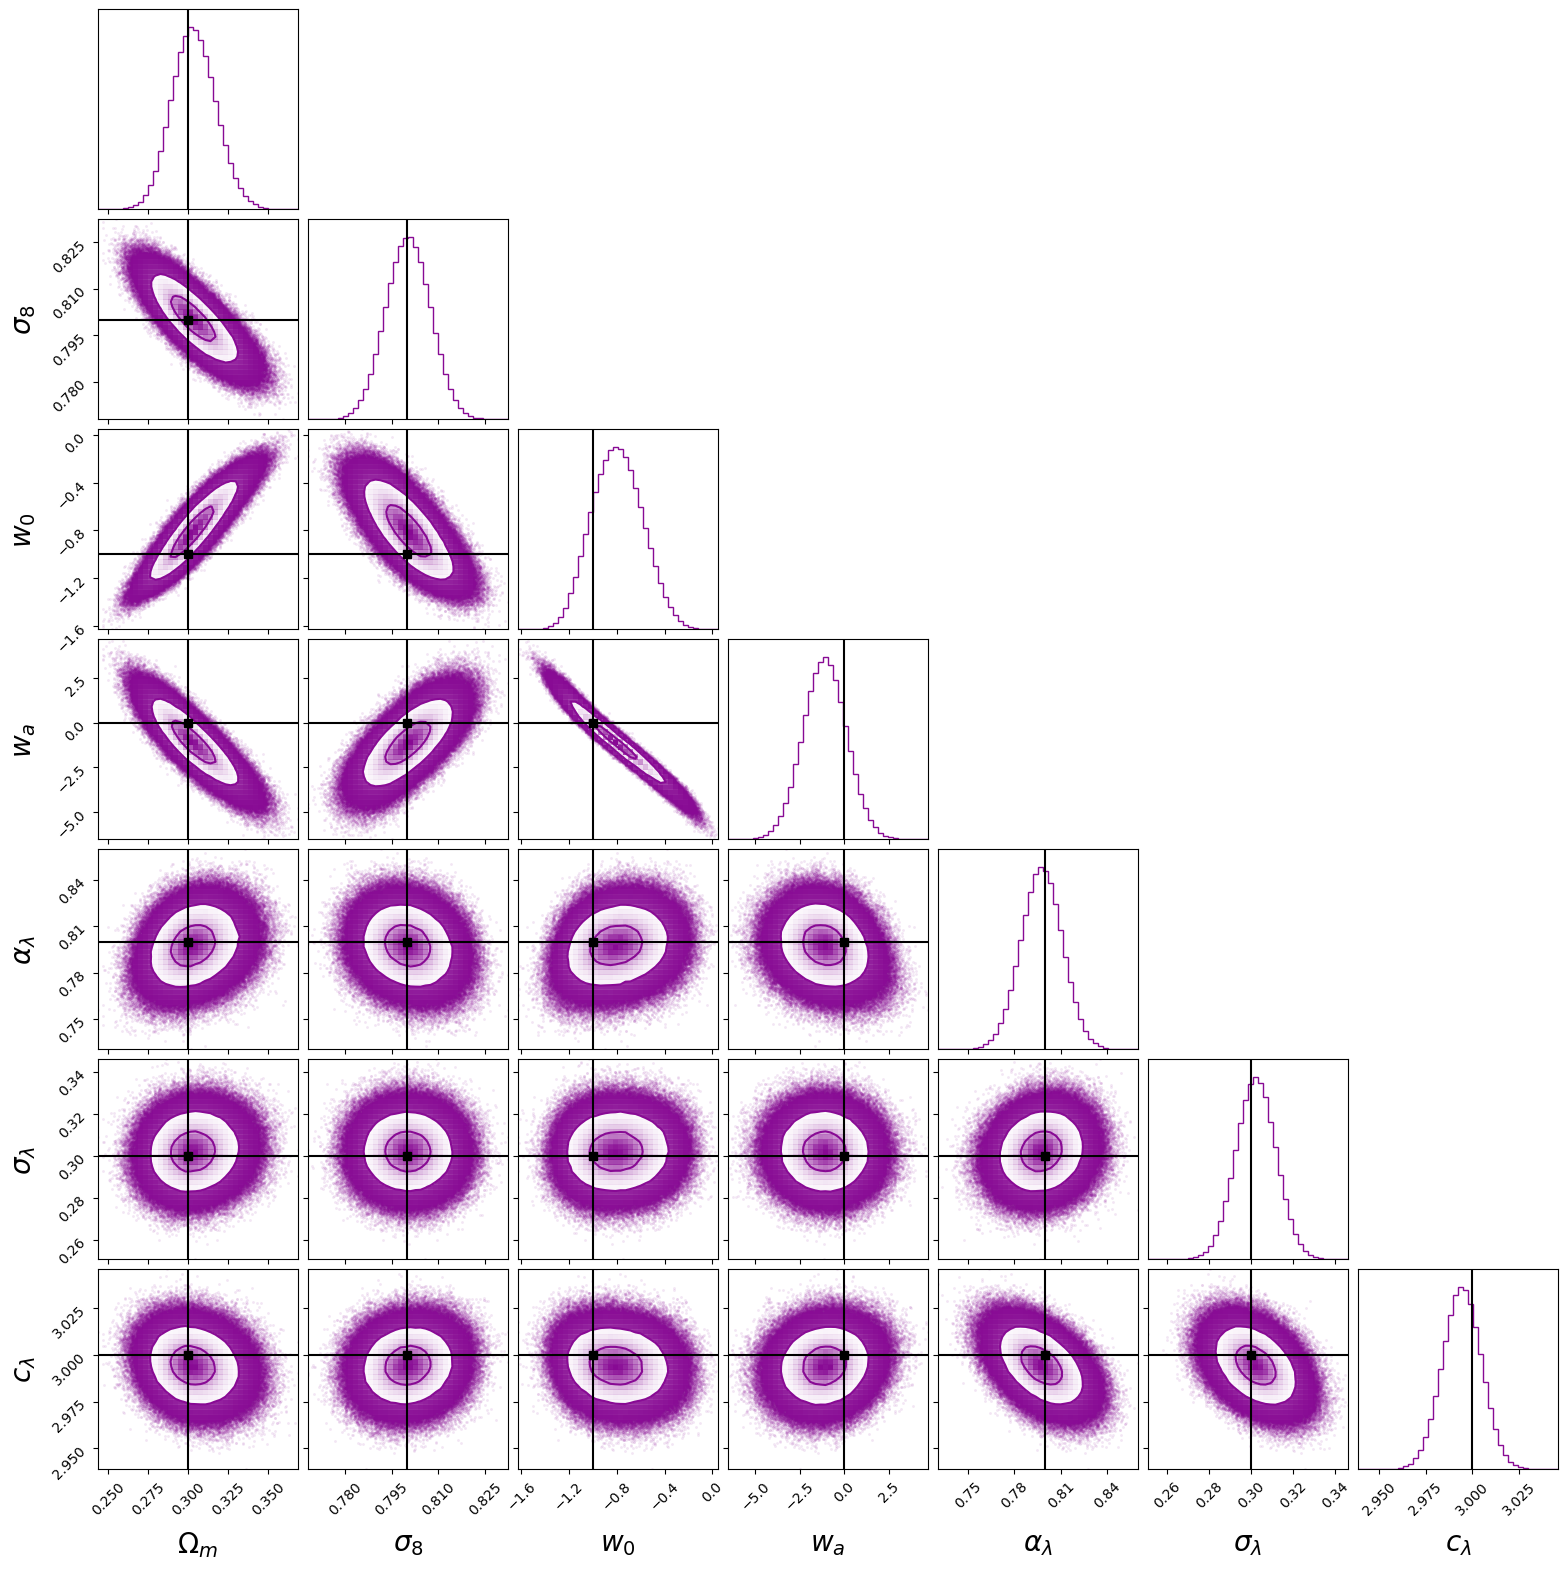

In [20]:
labels = ['$\Omega_m$' , '$\sigma_8$' , r'$w_0$' , r'$w_a$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$' ]
truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]



figure = corner.corner( samples_unbinned_posterior_w0wa.numpy(), 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#2d4ea1',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25} )

corner.corner( samples_stacked_posteriorw0war.numpy() , fig = figure , 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25}  )

plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = '3D stacked posteriors')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = '2D stacked posteriors + mean mass richness relation')
plt.legend( loc="upper right" )
# plt.savefig('both_bins_w0wa.pdf')


print()

In [25]:
up_centred_w0wa = samples_unbinned_posterior_w0wa.numpy() - np.median( samples_unbinned_posterior_w0wa.numpy() , axis = 0 ) + truths 
sp_centred_w0wa = samples_stacked_posterior_w0wa.numpy() - np.median( samples_stacked_posterior_w0wa.numpy() , axis = 0 ) + truths 

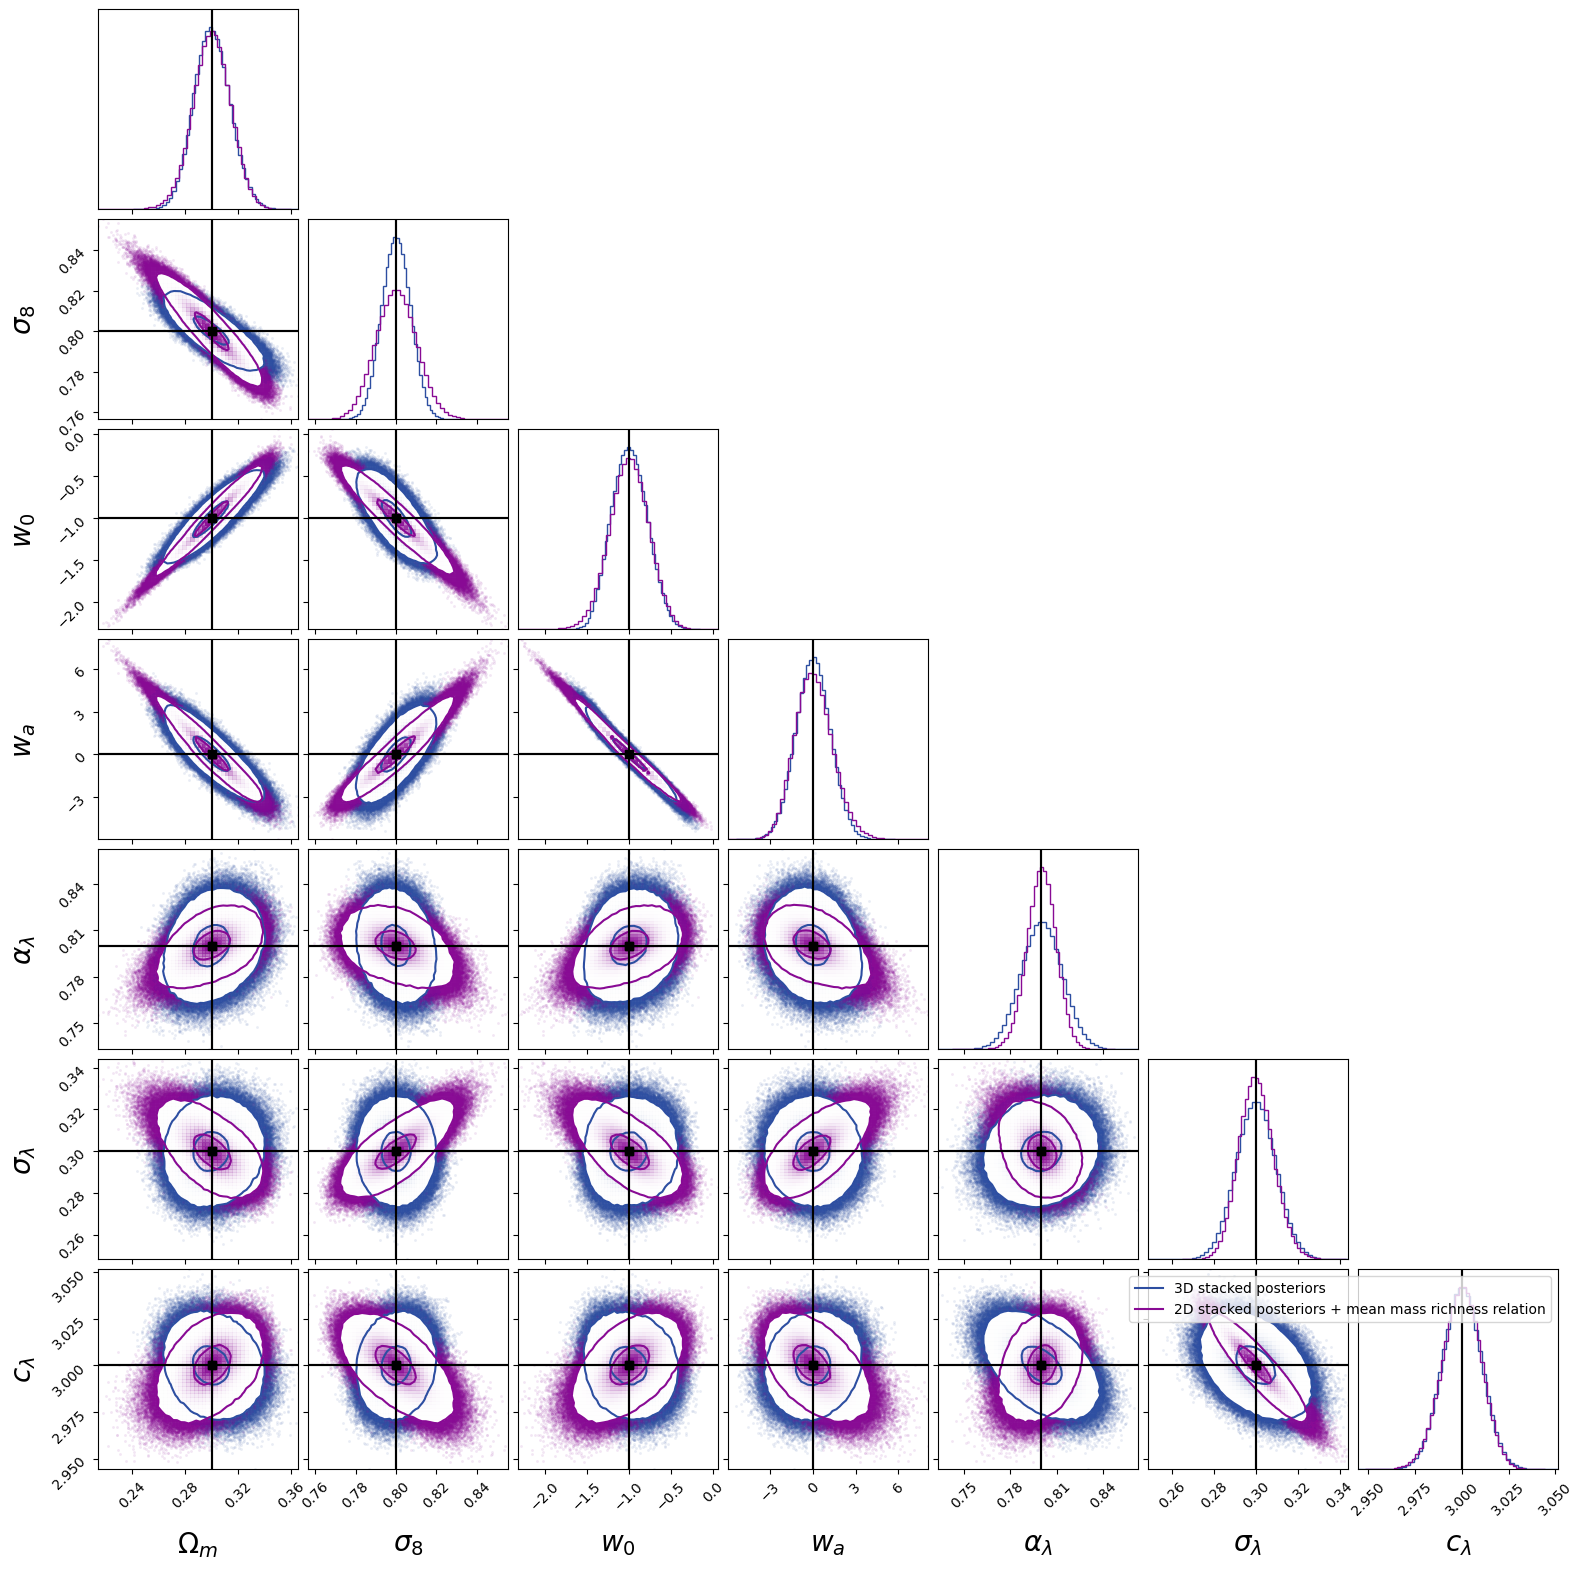

In [27]:
labels = ['$\Omega_m$' , '$\sigma_8$' , r'$w_0$' , r'$w_a$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$' ]
truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]



figure = corner.corner( up_centred_w0wa, 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#2d4ea1',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25} )

corner.corner( sp_centred_w0wa , fig = figure , 
               levels = [ 0.393 , 0.98 ] ,  
               bins = 50 , 
               hist_kwargs={'density': True},
               #range = limits,
               labels = labels,
               color ='#880a94',
               truths = truths,
               truth_color = 'k',
               label_kwargs={"fontsize": 20},
               title_kwargs={"fontsize": 25}  )

plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = '3D stacked posteriors')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = '2D stacked posteriors + mean mass richness relation')
plt.legend( loc="upper right" )
plt.savefig('both_bins_w0wa.pdf')


print()